In [30]:
import numpy as np
import matplotlib.pyplot as plt
m = 4  # Mach's number
L_d = 0.00001
L_h = L_d
a = 340.28  # speed of sound
P_free = 101325  # freestream pressure
T_free = 288.16  # freestream temperature
T_w = 288.16  # since T_w/T_free = 1
gamma = 1.4
mu_0 = 1.7894 * 10 ** (-5)  # viscousity
T_0 = 288.16 # initial temperature
R = 287 # Gas const
Pr = 0.71  # Prandtl number for perfect gas
u_free = m * a
c_v = R / (gamma - 1)
ro_free = P_free / (R * T_free)
dx = L_d / 20
dy = L_h / 20
x_list = np.arange(0, L_d + dx, dx)
y_list = np.arange(0, L_h + dy, dy)
dt = 2*10 ** (-10)
n = 0
u = [np.ones((len(y_list), len(x_list))) * u_free]
v = [np.zeros((len(y_list), len(x_list)))]
P = [np.ones((len(y_list), len(x_list))) * P_free]
T = [np.ones((len(y_list), len(x_list))) * T_free]
ro = [np.ones((len(y_list), len(x_list))) * ro_free]
mu = [np.zeros((len(y_list), len(x_list)))]
k = [np.zeros((len(y_list), len(x_list)))]

In [31]:
def boundary(u, v, P, T, ro):
    # left boundary condition
    for j in range(len(y_list)):
        u[j][0] = u_free
        v[j][0] = 0
        P[j][0] = P_free
        T[j][0] = T_free
        ro[j][0] = ro_free
    # upper boundary condition
    for i in range(len(x_list)):
        u[-1][i] = u_free
        v[-1][i] = 0
        P[-1][i] = P_free
        T[-1][i] = T_free
        ro[-1][i] = ro_free
    # lower boundary condition
    for i in range(len(x_list)):
        u[0][i] = 0
        v[0][i] = 0
        P[0][i] = 2 * P[1][i] - P[2][i]
        T[0][i] = T_w
        ro[0][i] = P[0][i] / (R * T[0][i])
    # right boundary condition
    for j in range(len(y_list)):
        u[j][-1] = 2 * u[j][-2] - u[j][-3]
        v[j][-1] = 2 * v[j][-2] - v[j][-3]
        P[j][-1] = 2 * P[j][-2] - P[j][-3]
        T[j][-1] = 2 * T[j][-2] - T[j][-3]
        ro[j][-1] = P[j][-1] / (R * T[j][-1])
    # boundary for first point
    u[0][0] = 0
    v[0][0] = 0
    P[0][0] = P_free
    T[0][0] = T_w
    ro[0][0] = ro_free
    return (u, v, P, T, ro)

u[n], v[n], P[n], T[n], ro[n] = boundary(u[n], v[n], P[n], T[n], ro[n])

In [32]:
def change_mu(T):
    global m_0, T_0
    return mu_0 * ((T / T_0) ** (3 / 2)) * ((T_0 + 110) / (T + 110))  # Sutherland's law for perfect gas


def change_k(mu, gamma, c_v, Pr):
    return (mu * (gamma * c_v)) / Pr

for j in range(len(y_list)):
    for i in range(len(x_list)):
        mu[n][j][i] = change_mu(T[n][j][i])

for j in range(len(y_list)):
    for i in range(len(x_list)):
        k[n][j][i] = change_k(mu[n][j][i], gamma, c_v, Pr)

In [33]:
def TAU_XX(u, v, mu, case):
    dx_list = np.zeros((len(y_list), len(x_list)))
    dy_list = np.zeros((len(y_list), len(x_list)))

    if case == 'predict_e':
        for j in range(len(y_list)):
            for i in range(len(x_list)):
                if i == 0:
                    dx_list[j][i] = (u[j][i + 1] - u[j][i]) / dx
                else:
                    dx_list[j][i] = (u[j][i - 1] - u[j][i]) / dx

    else:
        for j in range(len(y_list)):
            for i in range(len(x_list)):
                if i == len(x_list) - 1:
                    dx_list[j][i] = (u[j][i] - u[j][i - 1]) / dx
                else:
                    dx_list[j][i] = (u[j][i + 1] - u[j][i]) / dx

    for j in range(len(y_list)):
        for i in range(len(x_list)):
            if j == 0:
                dy_list[j][i] = (v[j + 1][i] - v[j][i]) / dy
            elif j == len(y_list) - 1:
                dy_list[j][i] = (v[j][i] - v[j - 1][i]) / dy
            else:
                dy_list[j][i] = (v[j + 1][i] - v[j - 1][i]) / (2 * dy)

    return -(2 / 3) * mu * (dx_list + dy_list) + 2 * mu * (dx_list)


def TAU_YY(u, v, mu, case):
    dx_list = np.zeros((len(y_list), len(x_list)))
    dy_list = np.zeros((len(y_list), len(x_list)))

    if case == 'predict_f':
        for j in range(len(y_list)):
            for i in range(len(x_list)):
                if j == 0:
                    dy_list[j][i] = (v[j + 1][i] - v[j][i]) / dy
                dy_list[j][i] = (v[j][i] - v[j - 1][i]) / dy
    else:
        for j in range(len(y_list)):
            for i in range(len(x_list)):
                if j == len(y_list) - 1:
                    dy_list[j][i] = (v[j][i] - v[j - 1][i]) / dy
                else:
                    dy_list[j][i] = (v[j + 1][i] - v[j][i]) / dy

    for j in range(len(y_list)):
        for i in range(len(x_list)):
            if i == 0:
                dx_list[j][i] = (u[j][i + 1] - u[j][i]) / dx
            elif i == len(x_list) - 1:
                dx_list[j][i] = (u[j][i] - u[j][i - 1]) / dx
            else:
                dx_list[j][i] = (u[j][i + 1] - u[j][i - 1]) / (2 * dx)

    return -(2 / 3) * mu * (dx_list + dy_list) + 2 * mu * (dy_list)


def TAU_XY(u, v, mu, case):
    dx_list = np.zeros((len(y_list), len(x_list)))
    dy_list = np.zeros((len(y_list), len(x_list)))

    if case == 'predict_e' or case == 'correct_e':

        for j in range(len(y_list)):
            for i in range(len(x_list)):
                if j == 0:
                    dy_list[j][i] = (u[j + 1][i] - u[j][i]) / (dy)
                elif j == len(y_list) - 1:
                    dy_list[j][i] = (u[j][i] - u[j - 1][i]) / (dy)
                else:
                    dy_list[j][i] = (u[j + 1][i] - u[j - 1][i]) / (2 * dy)

        if case == 'predict_e':
            for j in range(len(y_list)):
                for i in range(len(x_list)):
                    if i == 0:
                        dx_list[j][i] = (v[j][i + 1] - v[j][i]) / dx
                    else:
                        dx_list[j][i] = (v[j][i] - v[j][i - 1]) / dx
        else:
            for j in range(len(y_list)):
                for i in range(len(x_list)):
                    if i == len(x_list) - 1:
                        dx_list[j][i] = (v[j][i] - v[j][i - 1]) / dx
                    else:
                        dx_list[j][i] = (v[j][i + 1] - v[j][i]) / dx

    elif case == 'predict_f' or case == 'correct_f':
        for j in range(len(y_list)):
            for i in range(len(x_list)):
                if i == 0:
                    dx_list[j][i] = (v[j][i + 1] - v[j][i]) / (dx)
                elif i == len(x_list) - 1:
                    dx_list[j][i] = (v[j][i - 1] - v[j][i]) / (dx)
                else:
                    dx_list[j][i] = (v[j][i + 1] - v[j][i - 1]) / (2 * dx)

        if case == 'predict_f':
            for j in range(len(y_list)):
                for i in range(len(x_list)):
                    if j == 0:
                        dy_list[j][i] = (u[j + 1][i] - u[j][i]) / (dy)
                    else:
                        dy_list[j][i] = (u[j][i] - u[j - 1][i]) / (dy)
        else:
            for j in range(len(y_list)):
                for i in range(len(x_list)):
                    if j == len(y_list) - 1:
                        dy_list[j][i] = (u[j][i] - u[j - 1][i]) / (dy)
                    else:
                        dy_list[j][i] = (u[j + 1][i] - u[j][i]) / (dy)

    return mu * (dx_list + dy_list)


def Q_X(k, T, case):
    dT_list = np.zeros((len(y_list), len(x_list)))
    if case == 'predict_e':
        for j in range(len(y_list)):
            for i in range(len(x_list)):
                if i == 0:
                    dT_list[j][i] = (dT_list[j][i + 1] - dT_list[j][i]) / dx
                else:
                    dT_list[j][i] = (dT_list[j][i] - dT_list[j][i - 1]) / dx
    else:
        for j in range(len(y_list)):
            for i in range(len(x_list)):
                if i == len(x_list) - 1:
                    dT_list[j][i] = (dT_list[j][i] - dT_list[j][i - 1]) / dx
                else:
                    dT_list[j][i] = (dT_list[j][i + 1] - dT_list[j][i]) / dx

    return -k * dT_list


def Q_Y(k, T, case):
    dT_list = np.zeros((len(y_list), len(x_list)))
    if case == 'predict_f':
        for j in range(len(y_list)):
            for i in range(len(x_list)):
                if j == 0:
                    dT_list[j][i] = (dT_list[j + 1][i] - dT_list[j][i]) / dy
                else:
                    dT_list[j][i] = (dT_list[j][i] - dT_list[j - 1][i]) / dy
    else:
        for j in range(len(y_list)):
            for i in range(len(x_list)):
                if j == len(y_list) - 1:
                    dT_list[j][i] = (dT_list[j][i] - dT_list[j - 1][i]) / dy
                else:
                    dT_list[j][i] = (dT_list[j + 1][i] - dT_list[j][i]) / dy
                    
    return -k * dT_list

In [34]:
U1_ = np.zeros((len(y_list), len(x_list)))
U2_ = np.zeros((len(y_list), len(x_list)))
U3_ = np.zeros((len(y_list), len(x_list)))
U5_ = np.zeros((len(y_list), len(x_list)))
ro_ = np.zeros((len(y_list), len(x_list)))
u_ = np.zeros((len(y_list), len(x_list)))
v_ = np.zeros((len(y_list), len(x_list)))
T_ = np.zeros((len(y_list), len(x_list)))
e_ = np.zeros((len(y_list), len(x_list)))
P_ = np.zeros((len(y_list), len(x_list)))

for _ in range(100):
    tau_xx = TAU_XX(u[n], v[n], mu[n], 'predict_e')
    tau_yy = TAU_YY(u[n], v[n], mu[n], 'predict_e')
    tau_xy_e = TAU_XY(u[n], v[n], mu[n], 'predict_e')
    tau_xy_f = TAU_XY(u[n], v[n], mu[n], 'predict_f')

    q_x = Q_X(k[n], T[n], 'predict_e')
    q_y = Q_Y(k[n], T[n], 'predict_f')

    U1 = ro[n]
    U2 = ro[n] * u[n]
    U3 = ro[n] * v[n]
    U5 = ro[n] * (c_v * T[n] + (u[n] ** 2 + v[n] ** 2) / 2)

    E1 = ro[n] * u[n]
    E2 = ro[n] * (u[n] ** 2) + P[n] - tau_xx
    E3 = ro[n] * u[n] * v[n] - tau_xy_e
    E5 = (ro[n] * (c_v * T[n] + (u[n] ** 2 + v[n] ** 2) / 2) + P[n]) * u[n] - u[n] * tau_xx - v[n] * tau_xy_e + q_x

    F1 = ro[n] * v[n]
    F2 = ro[n] * u[n] * v[n] - tau_xy_f
    F3 = ro[n] * (v[n] ** 2) + P[n] - tau_yy
    F5 = (ro[n] * (c_v * T[n] + (u[n] ** 2 + v[n] ** 2) / 2) + P[n]) * v[n] - u[n] * tau_xy_f - v[n] * tau_yy + q_y

    for j in range(len(y_list) - 1):
        for i in range(len(x_list) - 1):
            U1_[j][i] = U1[j][i] - (dt / dx) * (E1[j][i + 1] - E1[j][i]) - (dt / dy) * (F1[j + 1][i] - F1[j][i])
            U2_[j][i] = U2[j][i] - (dt / dx) * (E2[j][i + 1] - E2[j][i]) - (dt / dy) * (F2[j + 1][i] - F2[j][i])
            U3_[j][i] = U3[j][i] - (dt / dx) * (E3[j][i + 1] - E3[j][i]) - (dt / dy) * (F3[j + 1][i] - F3[j][i])
            U5_[j][i] = U5[j][i] - (dt / dx) * (E5[j][i + 1] - E5[j][i]) - (dt / dy) * (F5[j + 1][i] - F5[j][i])

    for j in range(1, len(y_list) - 1):
        for i in range(1, len(x_list) - 1):
            ro_[j][i] = U1_[j][i]
            u_[j][i] = U2_[j][i] / U1_[j][i]
            v_[j][i] = U3_[j][i] / U1_[j][i]
            e_[j][i] = ((U5_[j][i] / U1_[j][i]) - ((u_[j][i] ** 2 + v_[j][i] ** 2) / 2))
            T_[j][i] = e_[j][i] / c_v
            P_[j][i] = ro_[j][i] * R * T_[j][i]

    u_, v_, P_, T_, ro_ = boundary(u_, v_, P_, T_, ro_)

    mu_ = np.zeros((len(y_list), len(x_list)))
    for j in range(len(y_list)):
        for i in range(len(x_list)):
            mu_[j][i] = change_mu(T_[j][i])

    k_ = np.zeros((len(y_list), len(x_list)))
    for j in range(len(y_list)):
        for i in range(len(x_list)):
            k_[j][i] = change_k(mu_[j][i], gamma, c_v, Pr)

    ro = np.append(ro, [np.zeros((len(y_list), len(x_list)))], axis=0)
    u = np.append(u, [np.zeros((len(y_list), len(x_list)))], axis=0)
    v = np.append(v, [np.zeros((len(y_list), len(x_list)))], axis=0)
    P = np.append(P, [np.zeros((len(y_list), len(x_list)))], axis=0)
    T = np.append(T, [np.zeros((len(y_list), len(x_list)))], axis=0)

    mu = np.append(mu, [np.zeros((len(y_list), len(x_list)))], axis=0)
    k = np.append(k, [np.zeros((len(y_list), len(x_list)))], axis=0)
    e = np.zeros((len(y_list), len(x_list)))

    tau_xx = TAU_XX(u_, v_, mu_, 'correct_e')
    tau_yy = TAU_YY(u_, v_, mu_, 'correct_e')
    tau_xy_e = TAU_XY(u_, v_, mu_, 'correct_e')
    tau_xy_f = TAU_XY(u_, v_, mu_, 'correct_f')

    q_x = Q_X(k_, T_, 'correct_e')
    q_y = Q_Y(k_, T_, 'correct_f')

    E1_ = ro_ * u_
    E2_ = ro_ * (u_ ** 2) + P_ - tau_xx
    E3_ = ro_ * u_ * v_ - tau_xy_e
    E5_ = (ro_ * (c_v * T_ + (u_ ** 2 + v_ ** 2) / 2) + P_) * u_ - u_ * tau_xx - v_ * tau_xy_e + q_x

    F1_ = ro_ * v_
    F2_ = ro_ * u_ * v_ - tau_xy_f
    F3_ = ro_ * (v_ ** 2) + P_ - tau_yy
    F5_ = (ro_ * (c_v * T_ + (u_ ** 2 + v_ ** 2) / 2) + P_) * v_ - u_ * tau_xy_f - v_ * tau_yy + q_y

    for j in range(len(y_list) - 1):
        for i in range(len(x_list) - 1):
            U1[j][i] = 0.5 * (U1[j][i] + U1_[j][i] - (dt / dx) * (E1_[j][i] - E1_[j][i - 1]) - (dt / dy) * (
                    F1_[j][i] - F1_[j - 1][i]))
            U2[j][i] = 0.5 * (U2[j][i] + U2_[j][i] - (dt / dx) * (E2_[j][i] - E2_[j][i - 1]) - (dt / dy) * (
                    F2_[j][i] - F2_[j - 1][i]))
            U3[j][i] = 0.5 * (U3[j][i] + U3_[j][i] - (dt / dx) * (E3_[j][i] - E3_[j][i - 1]) - (dt / dy) * (
                    F3_[j][i] - F3_[j - 1][i]))
            U5[j][i] = 0.5 * (U5[j][i] + U5_[j][i] - (dt / dx) * (E5_[j][i] - E5_[j][i - 1]) - (dt / dy) * (
                    F5_[j][i] - F5_[j - 1][i]))

    for j in range(1, len(y_list) - 1):
        for i in range(1, len(x_list) - 1):
            ro[n + 1][j][i] = U1[j][i]
            u[n + 1][j][i] = U2[j][i] / U1[j][i]
            v[n + 1][j][i] = U3[j][i] / U1[j][i]
            e[j][i] = (U5[j][i] / U1[j][i]) - ((u[n + 1][j][i] ** 2 + v[n + 1][j][i] ** 2) / 2)
            T[n + 1][j][i] = e[j][i] / c_v
            P[n + 1][j][i] = ro[n + 1][j][i] * R * T[n + 1][j][i]

    u[n + 1], v[n + 1], P[n + 1], T[n + 1], ro[n + 1] = boundary(u[n + 1], v[n + 1], P[n + 1], T[n + 1], ro[n + 1])

    for j in range(len(y_list)):
        for i in range(len(x_list)):
            mu[n + 1][j][i] = change_mu(T[n + 1][j][i])

    for j in range(len(y_list)):
        for i in range(len(x_list)):
            k[n + 1][j][i] = change_k(mu[n + 1][j][i], gamma, c_v, Pr)
    n += 1

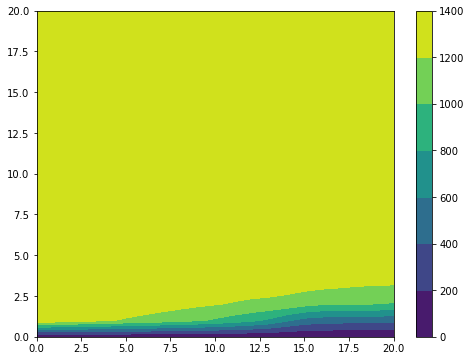

In [35]:
fig, ax = plt.subplots()
cp = ax.contourf(u[n-1])
fig.set_figwidth(8)
fig.set_figheight(6)
fig.colorbar(cp)
plt.show()

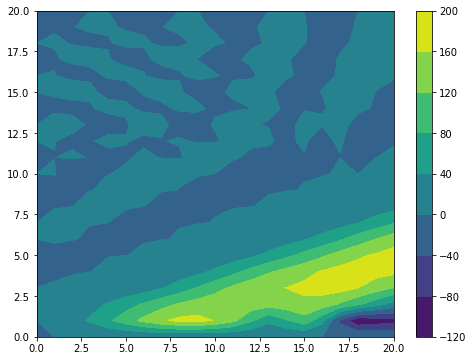

In [36]:
fig, ax = plt.subplots()
cp = ax.contourf(v[n-1])
fig.set_figwidth(8)
fig.set_figheight(6)
fig.colorbar(cp)
plt.show()

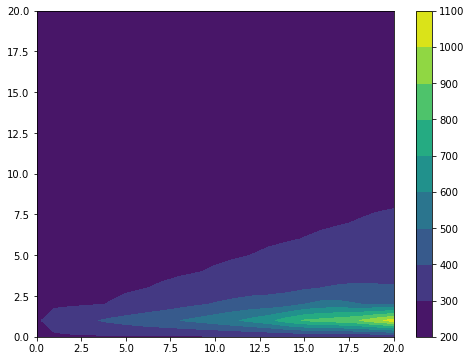

In [37]:
fig, ax = plt.subplots()
cp = ax.contourf(T[n-1])
fig.set_figwidth(8)
fig.set_figheight(6)
fig.colorbar(cp)
plt.show()

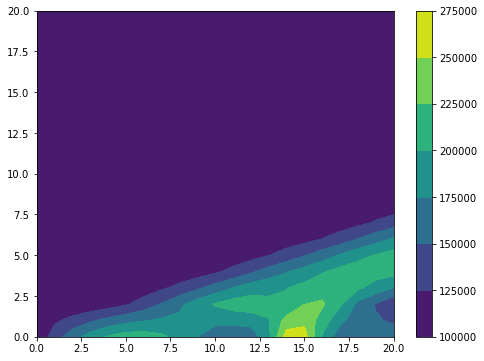

In [38]:
fig, ax = plt.subplots()
cp = ax.contourf(P[n-1])
fig.set_figwidth(8)
fig.set_figheight(6)
fig.colorbar(cp)
plt.show()